# Test of GraphSAGE
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:1


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)

In [5]:
datasets = ['train', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data/transR_50/train.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [6]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(16)

- Turn the print message to a log file

In [7]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transE_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1009_18:41_GraphSAGE_transE_50.log


### Model

In [15]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, hidden_dim, 'lstm')
        self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'lstm')
        self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [16]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [17]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [18]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [19]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [20]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[ 0.3074,  0.1499,  0.1534,  ...,  0.2805,  0.3043,  0.0125],
        [-0.0310,  0.3151,  0.2121,  ...,  0.2662,  0.0175, -0.2776],
        [ 0.1806,  0.0445, -0.1894,  ..., -0.2207, -0.0729, -0.3162],
        ...,
        [ 0.2344, -0.2313,  0.2761,  ..., -0.2362, -0.0874,  0.3126],
        [ 0.0225, -0.1066, -0.1116,  ..., -0.1634, -0.0884,  0.2932],
        [ 0.2843,  0.1079, -0.2939,  ..., -0.1879,  0.2469,  0.2686]],
       requires_grad=True)

- Check if model really load the model_dict

In [21]:
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[ 0.3074,  0.1499,  0.1534,  ...,  0.2805,  0.3043,  0.0125],
        [-0.0310,  0.3151,  0.2121,  ...,  0.2662,  0.0175, -0.2776],
        [ 0.1806,  0.0445, -0.1894,  ..., -0.2207, -0.0729, -0.3162],
        ...,
        [ 0.2344, -0.2313,  0.2761,  ..., -0.2362, -0.0874,  0.3126],
        [ 0.0225, -0.1066, -0.1116,  ..., -0.1634, -0.0884,  0.2932],
        [ 0.2843,  0.1079, -0.2939,  ..., -0.1879,  0.2469,  0.2686]],
       requires_grad=True)

In [22]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-2.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 30

# save the best model
best_val_loss = float('inf')
patience = 4  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['train'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        
#     scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break

  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/09/2023, 18:45:55# labels of 5000: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 142,  71,  71,  71,
         71,  71,  71,  35,  35,  65,  35,  35,  35,  35,  24,  17,  17,  17,
         17,  17,  17,  17

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/09/2023, 18:48:49# labels of Validation: tensor([  4,  49,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  41,  41,  41,
         41,  41, 153, 153, 153,  36,  40,  40,  40,  40,  40,  40, 122, 122,
        122, 122, 122, 122, 122,  29,  29,  29,  29,  29,  29,  29,  29,  29,
         29,  35,  35,  65,  35,  35,  35,  35, 109,  28,  28,  28,  28,  28,
         28,  28,  28,  28,  28,  28,  28,  34, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 116, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123], device='cuda:1') torch.Size([107])
10/09/2023, 18:48:49# predicted of Validation: tensor([ 13, 112,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  41,  41,  41,
         41,  41, 153, 153, 153, 108,  40,  40,  40,  40,  40,  40, 122, 122,
        122, 122, 122, 122, 122,  29,  2

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/09/2023, 18:53:31# labels of 5000: tensor([160, 160, 160,  ...,  25,  25,  25], device='cuda:1') torch.Size([2098])
10/09/2023, 18:53:31# predicted of 5000: tensor([160, 160, 160,  ...,  25,  25,  25], device='cuda:1') torch.Size([2098])
10/09/2023, 18:56:13# total batches: 8250
10/09/2023, 18:56:13# Epoch 1 | Train Loss: 0.2813 | Train Accuracy: 0.9340


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/09/2023, 18:56:13# labels of Validation: tensor([ 12,  43,  43, 126, 126, 126,  65, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 138, 138, 138, 138, 138, 138,
        138, 138, 138, 138, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 157,  80,  80,  80,  80,  80,  80,  59,  59,
         59,  62,  62,  62,  62,  62,  62,  27,  27,  27,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  73,  73,  73,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  65,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/09/2023, 18:56:43# Validation Loss: 0.2527 | Validation Accuracy: 0.9379

10/09/2023, 18:56:43# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/09/2023, 19:01:06# labels of 5000: tensor([ 19,  19,  19,  19,  19, 122, 122, 122, 122, 122, 122, 122,  65,  65,
         65,  65, 102, 102,  48,  55,  33,  13,  13,  13,  13,  13,  87, 109,
         33,  64,  64,  56,  56,  56,  56,  56,  56,  55, 151,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  14], device='cuda:1') torch.Size([89])
10/09/2023, 19:01:06# predicted of 5000: tensor([ 19,  19,  19,  19,  19, 122, 122, 122, 122, 122, 122, 122,  65,  65,
         65,  65, 102, 102,  33, 109,  75,  13,  13,  13,  13,  13,  31, 151,
         94,  94,  59,  56,  56,  56,  56,  56,  56, 158,  94,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,  70,  70, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/09/2023, 19:03:59# labels of Validation: tensor([  5,   5,   5,  81,  67,  67,  67,  67,  67, 121, 102, 102, 144, 157,
          1, 137, 137, 137, 137, 137,  40,  40,  40,  40,  40,  40,  65, 102,
        102, 137, 137, 137, 137, 137,  59,  59,  59, 164,  73,  73,  73,  95,
         95,  95], device='cuda:1') torch.Size([44])
10/09/2023, 19:03:59# predicted of Validation: tensor([  5,   5,   5,  79,  78,  78,  78,  78,  78,  59, 102, 102,  24, 111,
        151, 137, 137, 137, 137, 137,  40,  40,  40,  40,  40,  40,  65, 102,
        102, 137, 137, 137, 137, 137, 113, 113, 113,  24,  73,  73,  73,  95,
         95,  95], device='cuda:1') torch.Size([44])
10/09/2023, 19:03:59# labels of 0: tensor([  5,   5,   5,  81,  67,  67,  67,  67,  67, 121, 102, 102, 144, 157,
          1, 137, 137, 137, 137, 137,  40,  40,  40,  40,  40,  40,  65, 102,
        102, 137, 137, 137, 137, 137,  59,  59,  59, 164,  73,  73,  73,  95,
         95,  95], device='cuda:1') torch.Size([44])
10/09/2023, 1

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/09/2023, 19:08:51# labels of 5000: tensor([ 33,  20,  20,  84,  84,  84,  84,  84,  84,  84,  84,  84,  37,  37,
         37,  37,  37, 137, 137, 137, 137, 137,  80,  80,  80,  80,  80,  80,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 153,
        153, 153,  90,  90,  14,  15,  15,  15,  41,  41,  41,  41,  41,  81,
         93,  93, 144, 152], device='cuda:1') torch.Size([88])
10/09/2023, 19:08:51# predicted of 5000: tensor([112,  20,  20,  84,  84,  84,  84,  84,  84,  84,  84,  84,  37,  37,
         37,  37,  37, 137, 137, 137, 137, 137,  80,  80,  80,  80,  80,  80,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 153,


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/09/2023, 19:11:29# labels of Validation: tensor([  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3, 155, 155, 155, 155, 110, 110, 129, 129, 129, 129, 129, 129, 129,
         57,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 100, 100, 100,
        100, 100, 100, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/09/2023, 19:12:00# Validation Loss: 0.2367 | Validation Accuracy: 0.9392

10/09/2023, 19:12:00# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

KeyboardInterrupt: 

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [23]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-2.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/1032 [00:00<?, ?it/s]

10/09/2023, 19:14:28# labels of Test: tensor([65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65,
  

10/09/2023, 19:14:49# labels of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120],
       device='cuda:1') torch.Size([96])
10/09/2023, 19:14:49# predicted of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/09/2023, 19:15:32# report path: classification_report/classification_report-transE_50-graphSAGE-0.xlsx
10/09/2023, 19:15:32# label path: classification_report/mapped_true_predicted_labels-transE_50-graphSAGE-0.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/09/2023, 19:15:44# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.00      0.00      0.00       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.00      0.00      0.00       100
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.00      0.00      0.00       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.15      0.23      0.18     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,6400.000000
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,600.000000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.000000
T1003.002_7fa4ea18694f2552547b65e23952cabb,1.000000,1.000000,1.000000,1500.000000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.000000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,1.000000,1.000000,600.000000
benign,1.000000,1.000000,1.000000,134563.000000
accuracy,0.972514,0.972514,0.972514,0.972514
macro avg,0.590619,0.605342,0.591027,310263.000000


In [53]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [85]:
# # threshold = 0
# # filtered_report = report_df[report_df['f1-score'] == threshold]
# # print("Number of rows:", filtered_report.shape[0])

filtered_report = report_df[(report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]
num_rows = filtered_report.shape[0]
print("Number of support=200 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] > 200)]
num_rows = filtered_report.shape[0]
print("Number of support>200 and f1-score=0:", num_rows)

threshold = 0 
filtered_report = report_df[report_df['f1-score'] == threshold]
# print("Number of rows:", filtered_report.shape[0])


# filtered_report

Number of support=100: 54
Number of support=100 and f1-score<=0.2: 53
Number of support=100 and f1-score=0: 48
Number of support=200 and f1-score=0: 6
Number of support>200 and f1-score=0: 0


In [88]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 48


,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.0,0.0,0.0,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.0,0.0,0.0,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.0,0.0,0.0,100.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.0,0.0,0.0,100.0
T1016_71b3d2945679566b9d94d8cb11df4b70,0.0,0.0,0.0,100.0
T1016_921055f4-5970-4707-909e-62f594234d91,0.0,0.0,0.0,100.0
T1016_a0676fe1-cd52-482e-8dde-349b73f9aa69,0.0,0.0,0.0,100.0
T1016_e8017c46-acb8-400c-a4b5-b3362b5b5baa,0.0,0.0,0.0,100.0
T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517,0.0,0.0,0.0,100.0
T1018_a44bb43474728496276d5d73aa14588f,0.0,0.0,0.0,100.0


In [69]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

labels_indices = filtered_report.index.tolist()
print("Filtered Report Indices:", labels_indices)

mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
print(mapped_labels)

with open('triplets_2.txt', 'w') as f:
    for label in mapped_labels:
        f.write(f'{label}\n')

print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 6
Filtered Report Indices: ['T1036.004_7de3d7b4922a7b996d8df36fb22bb118', 'T1053.005_5db2884b6ca3ab932848f295a3896dc0', 'T1490_8467c994685ccf178db166964bd80fab', 'T1531_aa6b15485a5f50ced34d87fda177b758', 'T1531_b25ae80dad74142fafb510e9c1949ace', 'T1562.004_280003641a5cddf916c4f2bf605a71d3']
[110, 68, 88, 103, 114, 8]
6 labels have been written to filtered_labels.txt


,precision,recall,f1-score,support
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.0,0.0,0.0,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.0,0.0,0.0,200.0
T1490_8467c994685ccf178db166964bd80fab,0.0,0.0,0.0,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.0,0.0,0.0,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.0,0.0,0.0,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.0,0.0,0.0,200.0


In [70]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 0


,precision,recall,f1-score,support


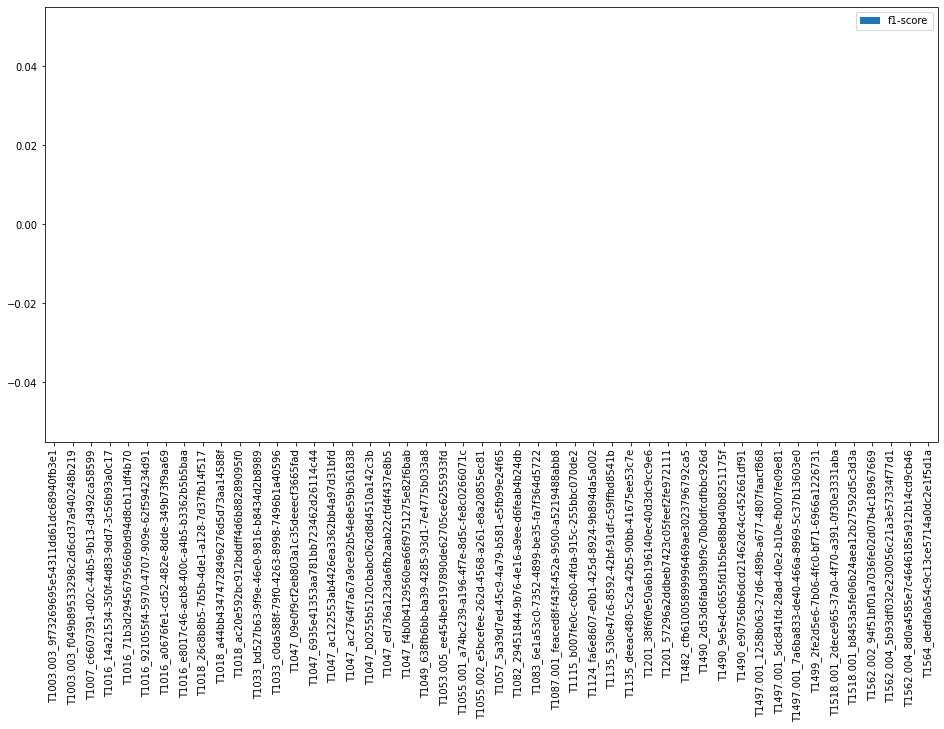

In [89]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
# filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] <= 200)]
# filtered_report = report_df[(report_df['support'] <= 200)]
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()